In [1]:
import sys
import os
import numpy as np
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import time
from tqdm import tqdm

Using TensorFlow backend.
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fouriest/anaconda3/lib/python3.7/site-packag

In [2]:
"""some misc plotting parameters"""

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000), # orange
                     (0.5000, 0.5000, 0.5000)] # grey

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
%matplotlib inline
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (10,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
rcParams['legend.fontsize'] = 'small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [ ]:
"""running NN 3x"""
data1 = np.genfromtxt('182392_timing.csv', delimiter=',')
t1 = data1[:,0]
y1 = data1[:,1]

y1 = y1[t1<4000]
t1 = t1[t1<4000]

y1 = y1[t1>1500]
t1 = t1[t1>1500]

t1 = t1/1000

In [ ]:
"""running NN once"""
data2 = np.genfromtxt('182508_timing.csv', delimiter=',')
t2 = data2[:,0]
y2 = data2[:,1]

y2 = y2[t2<4000]
t2 = t2[t2<4000]

y2 = y2[t2>1500]
t2 = t2[t2>1500]

t2 = t2/1000

In [ ]:
"""this model had 45485 parameters"""
"""30x 1d convolutions, 2x LSTM, ~30x reshape/concatenate/split"""

fig, ax = plt.subplots(figsize=(4,2))
# ax.plot(t1,y1, lw=1)
ax.plot(t2,y2,lw=1)
ax.set_ylim(1600,1700)
ax.set_xlabel("Experiment Time (s)", fontsize=8)
ax.set_ylabel("Calculation Time ($\mu$s)", fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
fig.savefig('shot_182508_timing.pdf')
fig.savefig('shot_182508_timing.png')

In [ ]:
print("y1 mean: ",np.mean(y1))
print("y1 std: ",np.std(y1))
print("y2 mean: ",np.mean(y2))
print("y2 std: ",np.std(y2))

In [3]:
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../tests'))



In [83]:
subprocess.run(['which','asle'])

CompletedProcess(args=['which', 'asle'], returncode=1)

In [4]:
os.chdir('../')
os.getcwd()

'/home/fouriest/SCHOOL/Princeton/PPPL/keras2c'

In [52]:
def build_and_run(name, return_output=False, cc='gcc'):

    cwd = os.getcwd()
    os.chdir(os.path.abspath('./include/'))
    lib_code = subprocess.run(['make','CC={}'.format(cc)]).returncode
    os.chdir(os.path.abspath(cwd))
    if lib_code != 0:
        return 'lib build failed'

    ccflags = ' -O3 -std=c99 -I./include/'
    if cc=='gcc':
        ccflags += ' -march=native'
    elif cc=='icc':
        ccflags += ' -xHost'
        
    comp = cc + ccflags + ' -o ' + name + ' ' + name + '.c ' + \
        name + '_test_suite.c -L./include/ -l:libkeras2c.a -lm'
    build_code = subprocess.run(comp.split()).returncode
    if build_code != 0:
        return 'build failed'
    
    if return_output:
        proc_output = subprocess.run(['./' + name],capture_output=True, text=True)
    else:
        proc_output = subprocess.run(['./' + name])
    rcode = proc_output.returncode
    if rcode == 0:
        if not os.environ.get('CI'):
            subprocess.run('rm ' + name + '*', shell=True)
            return (rcode, proc_output.stdout) if return_output else rcode
    return rcode

In [53]:
def time_model(model,num_tests,num_runs):
    pytimes = np.zeros(num_runs)
    ctimes = np.zeros(num_runs)
    nparams = model.count_params()

    k2c(model,'foo',num_tests=num_tests,malloc=False,verbose=False)
    out = build_and_run('foo',True,'icc')[1]
    
    for j in range(num_runs):
        ctimes[j] = float(out.split('\n')[0].split(' ')[-3])
        
    inp = np.random.random((num_tests,*model.input_shape[1:]))
    inp = np.expand_dims(inp,1)
    for j in range(num_runs):
        t0 = time.time_ns()
        for i in range(num_tests):
            _ = model.predict(inp[i])
        t1 = time.time_ns()
        pytimes[j] = (t1-t0)/10**9/num_tests
    return nparams, ctimes, pytimes

In [56]:
time_data = {}

In [58]:
"""Dense Model"""
size = []
ctimes = []
pytimes = []
save_dims = []
save_layers = []

num_tests = 10
num_runs = 10
nlayers = [1,2,4]
dims = [8,16,32]

for nl in nlayers:
    for dim in dims:
        inshp=(dim,)
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(dim,input_shape=inshp, activation='relu'))
        if nl>1:
            for i in range(nl-1):
                model.add(keras.layers.Dense(dim, activation='relu'))     
        model.build()
        nparams, ctime, pytime = time_model(model,num_tests,num_runs)
        size.append(nparams)
        ctimes.append(ctime)
        pytimes.append(pytime)
        save_dims.append(dim)
        save_layers.append(nl)

time_data['Fully Connected'] = {'size': size,
                      'layers': save_layers,
                      'dim': save_dims,
                      'ctimes':ctimes,
                      'pytimes':pytimes}

In [59]:
"""Conv1D Model"""
size = []
ctimes = []
pytimes = []
save_dims = []
save_layers = []

num_tests = 10
num_runs = 10
nlayers = [1,2,4]
dims = [8,16,32]


for nl in nlayers:
    for dim in dims:
        inshp=(dim,4)
        model = keras.models.Sequential()
        model.add(keras.layers.Conv1D(4,kernel_size=int(dim**.5),input_shape=inshp, padding='same'))
        if nl>1:
            for i in range(nl-1):
                model.add(keras.layers.Conv1D(10 + 2*i,kernel_size=int(dim**.5), padding='same'))
        
        model.build()
        nparams, ctime, pytime = time_model(model,num_tests,num_runs)
        size.append(nparams)
        ctimes.append(ctime)
        pytimes.append(pytime)
        save_dims.append(dim)
        save_layers.append(nl)

time_data['Conv1D'] = {'size': size,
                      'layers': save_layers,
                      'dim': save_dims,
                      'ctimes':ctimes,
                      'pytimes':pytimes}

In [77]:
"""Conv2D Model"""
size = []
ctimes = []
pytimes = []
save_dims = []
save_layers = []

num_tests = 10
num_runs = 10
nlayers = [1,2,4]
dims = [8,12,16,24,32]


for nl in nlayers:
    for dim in dims:
        inshp=(dim,dim,3)
        model = keras.models.Sequential()
        model.add(keras.layers.Conv2D(5,kernel_size=int(np.log2(dim)),input_shape=inshp,padding='same'))
        if nl>1:
            for i in range(nl-1):
                model.add(keras.layers.Conv2D(10+2*i**2,kernel_size=int(np.log2(dim)), padding='same'))

        model.build()
        nparams, ctime, pytime = time_model(model,num_tests,num_runs)
        size.append(nparams)
        ctimes.append(ctime)
        pytimes.append(pytime)
        save_dims.append(dim)
        save_layers.append(nl)

time_data['Conv2D'] = {'size': size,
                      'layers': save_layers,
                      'dim': save_dims,
                      'ctimes':ctimes,
                      'pytimes':pytimes}


In [61]:
"""LSTM Model"""
size = []
ctimes = []
pytimes = []
save_dims = []
save_layers = []

num_tests = 10
num_runs = 10
nlayers = [1,2,4]
dims = [8,16,32]


for nl in nlayers:
    for dim in dims:
        inshp=(int(np.sqrt(dim)),dim)
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(dim,return_sequences=True,input_shape=inshp))
        if nl>1:
            for i in range(nl-1):
                model.add(keras.layers.LSTM(dim,return_sequences=True,input_shape=inshp))
                
        model.build()
        nparams, ctime, pytime = time_model(model,num_tests,num_runs)
        size.append(nparams)
        ctimes.append(ctime)
        pytimes.append(pytime)
        save_dims.append(dim)
        save_layers.append(nl)

time_data['LSTM'] = {'size': size,
                      'layers': save_layers,
                      'dim': save_dims,
                      'ctimes':ctimes,
                      'pytimes':pytimes}


In [ ]:
import pickle
with open('k2c_benchmark_times.pkl','wb+') as f:
    pickle.dump(time_data,f)

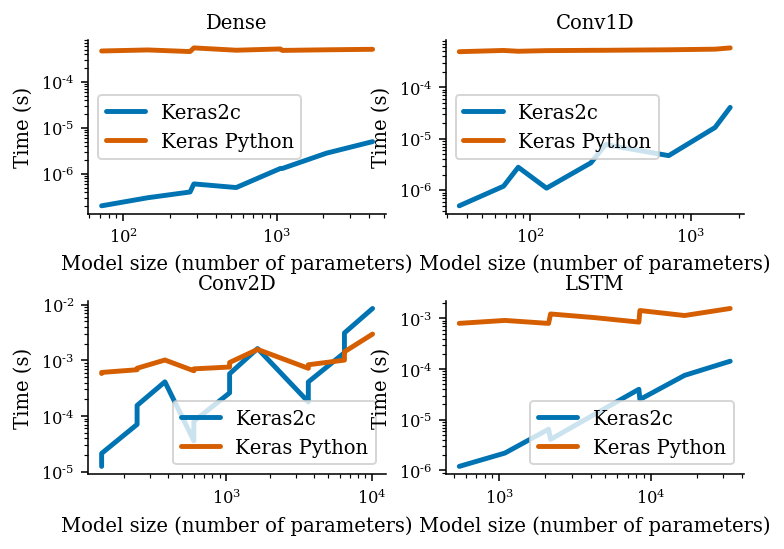

In [78]:
fig, ax = plt.subplots(2,2,figsize=(6,4))
ax = ax.flatten()

models = list(time_data.keys())
for i, model in enumerate(models):
    x = np.array(time_data[model]['size'])
    y1 = np.array([np.mean(foo) for foo in time_data[model]['ctimes']])
    y2 = np.array([np.mean(foo) for foo in time_data[model]['pytimes']])
    idx = np.argsort(x)
    x = x[idx]
    y1 = y1[idx]
    y2 = y2[idx]
    ax[i].loglog(x,y1,c=colorblind_colors[0],label='Keras2c')
    ax[i].loglog(x,y2,c=colorblind_colors[1],label='Keras Python')
    ax[i].legend(fontsize=10)
    ax[i].set_ylabel('Time (s)',fontsize=10)
    ax[i].set_xlabel('Model size (number of parameters)',fontsize=10)
    ax[i].set_title(model,fontsize=10)


plt.subplots_adjust(hspace=0.5)
# plt.savefig('benchmarking.png',bbox_inches='tight')

In [ ]:
import pydot
from IPython.display import SVG

graph = pydot.Dot(graph_type='digraph')

nodes = {'Keras2c C library': pydot.Node("Keras2c C library", shape='box', style="filled", fillcolor="darkorchid1"),
        'Trained Keras model':pydot.Node("Trained Keras model", shape='box', style="filled", fillcolor="firebrick2"),
        'Keras2c Python script':pydot.Node("Keras2c Python script", shape='box', style="filled", fillcolor="deepskyblue"),
        'Model weights/parameters':pydot.Node("Model weights/parameters", shape='box', style="filled", fillcolor="firebrick2"),
        'Model architecture':pydot.Node("Model architecture", shape='box', style="filled", fillcolor="firebrick2"),
        'Sample I/O pairs':pydot.Node("Sample I/O pairs", shape='box', style="filled", fillcolor="firebrick2"),
        'Generated C function':pydot.Node("Generated C function", shape='box', style="filled", fillcolor="darkorchid1"),
        'Automatic testing/verification':pydot.Node("Automatic testing/verification", shape='box', style="filled", fillcolor="deepskyblue"),
        'Callable C neural net function':pydot.Node("Callable C neural net function", shape='box', style="filled", fillcolor="darkorchid1")}         


for k,v in nodes.items():
    graph.add_node(v)

graph.add_edge(pydot.Edge(nodes['Trained Keras model'], nodes['Keras2c Python script']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model weights/parameters']))

graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Model architecture']))
graph.add_edge(pydot.Edge(nodes['Keras2c Python script'], nodes['Sample I/O pairs']))
graph.add_edge(pydot.Edge(nodes['Keras2c C library'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model weights/parameters'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Model architecture'], nodes['Generated C function']))
graph.add_edge(pydot.Edge(nodes['Generated C function'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Sample I/O pairs'],nodes['Automatic testing/verification']))
graph.add_edge(pydot.Edge(nodes['Automatic testing/verification'],nodes['Callable C neural net function']))




graph.write_png('k2c_flow_graph.png')
SVG(graph.create(prog='dot', format='svg'))


In [ ]:
import pydot
from IPython.display import SVG

graph = pydot.Dot(graph_type='digraph')

nodes = {'profiles': pydot.Node("State (time=t)", shape='box', style="filled", fillcolor="deepskyblue"),
        'actuators':pydot.Node("Actuator (t-T thru t)", shape='box', style="filled", fillcolor="deepskyblue"),
        'LSTM':pydot.Node("LSTM", shape='box', style="filled", fillcolor="chartreuse2"),
        'inception':pydot.Node("Inception Blocks (multi resolution convolutions)", shape='box', style="filled", fillcolor="darkgoldenrod1"),
        'merge':pydot.Node("Merge", shape='box', style="filled", fillcolor="firebrick2"),
        'conv':pydot.Node("Convolutions", shape='box', style="filled", fillcolor="darkgoldenrod1"),
        'output':pydot.Node("State (time=t+1)", shape='box', style="filled", fillcolor="deepskyblue"),
       }         


for k,v in nodes.items():
    graph.add_node(v)

graph.add_edge(pydot.Edge(nodes['profiles'], nodes['inception']))
graph.add_edge(pydot.Edge(nodes['actuators'], nodes['LSTM']))

graph.add_edge(pydot.Edge(nodes['LSTM'], nodes['merge']))
graph.add_edge(pydot.Edge(nodes['inception'], nodes['merge']))
graph.add_edge(pydot.Edge(nodes['merge'], nodes['conv']))
graph.add_edge(pydot.Edge(nodes['conv'], nodes['output']))



graph.write_png('model_arch.png')
SVG(graph.create(prog='dot', format='svg'))
